In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('fake_job_postings.csv')

In [ ]:
# check null share per column
print(df.isnull().sum() / len(df))

job_id                 0.000000
title                  0.000000
location               0.019351
department             0.645805
salary_range           0.839597
company_profile        0.185011
description            0.000056
requirements           0.150783
benefits               0.403356
telecommuting          0.000000
has_company_logo       0.000000
has_questions          0.000000
employment_type        0.194128
required_experience    0.394295
required_education     0.453300
industry               0.274217
function               0.361018
fraudulent             0.000000
dtype: float64


In [ ]:
# replacing all null values with empty strings
for col in df.columns:
    if df[col].dtype == 'object' and col != 'location':
      df[col] = df[col].fillna('')
    elif col == 'location':
      df[col] = df[col].fillna(',,')

print(df.isnull().sum() / len(df))

job_id                 0.0
title                  0.0
location               0.0
department             0.0
salary_range           0.0
company_profile        0.0
description            0.0
requirements           0.0
benefits               0.0
telecommuting          0.0
has_company_logo       0.0
has_questions          0.0
employment_type        0.0
required_experience    0.0
required_education     0.0
industry               0.0
function               0.0
fraudulent             0.0
dtype: float64


<Axes: xlabel='Fraudulent', ylabel='Count'>

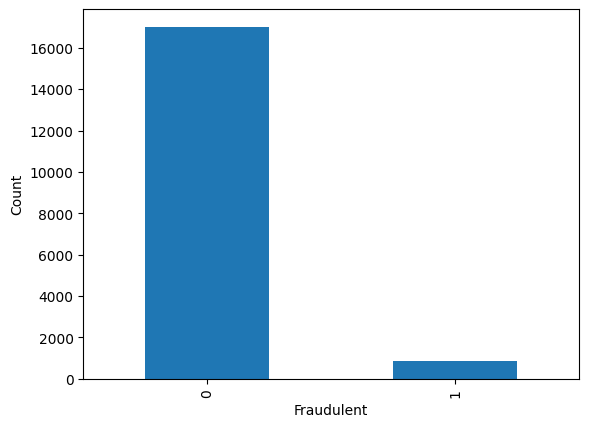

In [ ]:
classes_split = df['fraudulent'].value_counts()
classes_split.plot(kind="bar", xlabel="Fraudulent", ylabel="Count")

We can see that the dataset is very imbalanced in terms of the two classes.

In [ ]:
# further EDA

for col in df:
  print(f"{col}: {df[col].nunique()}")

print(df.head())

job_id: 17880
title: 11231
location: 3106
department: 1338
salary_range: 875
company_profile: 1710
description: 14802
requirements: 11968
benefits: 6205
telecommuting: 2
has_company_logo: 2
has_questions: 2
employment_type: 6
required_experience: 8
required_education: 14
industry: 132
function: 38
fraudulent: 2
   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing               We're Food52, and we've created a groundbreaki...   
1    Success               90 Seconds, the worlds Cloud Video Producti

The format of the *location* column is ```Country, Region, City```, so we can replace it with three separate columns.

In [ ]:
# merging all the text columns

df['text_data'] = df['title'] + ' ' + df['department'] + ' '\
+ df['company_profile'] + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits']

df.drop(columns=['title', 'department', 'company_profile', 'description', 'requirements', 'benefits'], inplace=True)
print(df.head())

   job_id salary_range  telecommuting  has_company_logo  has_questions  \
0       1                           0                 1              0   
1       2                           0                 1              0   
2       3                           0                 1              0   
3       4                           0                 1              0   
4       5                           0                 1              1   

  employment_type required_experience required_education  \
0           Other          Internship                      
1       Full-time      Not Applicable                      
2                                                          
3       Full-time    Mid-Senior level  Bachelor's Degree   
4       Full-time    Mid-Senior level  Bachelor's Degree   

                    industry              function  fraudulent country region  \
0                                        Marketing           0      US     NY   
1  Marketing and Advertising    

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# zrezygnowano z oversamplingu, gdyż pogarszał wyniki


x_train, x_test, y_train, y_test = train_test_split(df['text_data'], df['fraudulent'], test_size=0.2, random_state=42)

# vectorizer pozwala przetwarzać dane tekstowe jako wektory liczb odpowiadających wystąpieniom słów
vectorizer = TfidfVectorizer(
    strip_accents='unicode',
    max_df=10,
)

model1 = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('classifier', RandomForestClassifier())
    ]
)

model2 = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('classifier', MLPClassifier())
    ]
)

model3 = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('classifier', SVC(gamma=2, C=1, random_state=32))
    ]
)

model = VotingClassifier([('model1', model1), ('model2', model2), ('model3', model3)])

model.fit(x_train, y_train)

print(model.score(x_test, y_test))



0.9670022371364653


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_predicted = model.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_predicted)

print(conf_matrix)
print(classification_report(y_test, y_predicted))


[[3394    1]
 [ 117   64]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3395
           1       0.98      0.35      0.52       181

    accuracy                           0.97      3576
   macro avg       0.98      0.68      0.75      3576
weighted avg       0.97      0.97      0.96      3576



Na podstawie tych danych można stwierdzić, że model dobrze wykonuje najważniejsze zadania - bardzo rzadko oznacza autentyczne ogłoszenia jako fałszywe (recall dla klasy '0' na poziomie 1.00). Niezbyt dobrze radzi sobie z odfiltrowywaniem fałszywych ogłoszeń, ale co do tych, które jako fałszywe oznacza, można mieć dużą pewność.
